# CA3 - The banana syndicate

In [28]:
import pandas as pd
import seaborn as sns 
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## 1. Reading and visualisation
The first step is to read in the data and visualise it with an SNS pairplot to see distribution of the data.
This will be used for further decisionmaking

In [29]:
traindata = pd.read_csv("data/train.csv")
testdata = pd.read_csv("data/test.csv")

# Summing up the missing nan values for each feature
# Since there are no missing values, no values are removed
missing_values = traindata.isnull().sum()
print(missing_values)

traindata.head()

Size              0
Weight            0
Sweetness         0
Softness          0
HarvestTime       0
Ripeness          0
Acidity           0
Peel Thickness    0
Banana Density    0
Quality           0
dtype: int64


Size    Weight  Sweetness  Softness  HarvestTime  Ripeness   Acidity  \
0 -1.825734 -0.883754  -2.423530 -1.198136    -4.286523  1.585792 -0.589002   
1 -0.142286 -0.708374  -2.224219  2.222650     1.896814 -4.284821  1.069387   
2 -1.957254 -4.293733  -1.073703 -1.405019    -0.729812  3.930497 -0.397840   
3 -2.168043  3.095472   1.707717 -0.584218    -0.564767  0.014740 -0.103799   
4 -3.149338  3.058402   2.173671 -0.265609    -2.563220  0.376015  1.434252   

   Peel Thickness  Banana Density  Quality  
0        0.164434    65822.758426        0  
1        0.704945    99930.329162        0  
2        0.852810    37081.567982        0  
3        0.582909    63931.435551        1  
4        0.102162    48711.448819        1

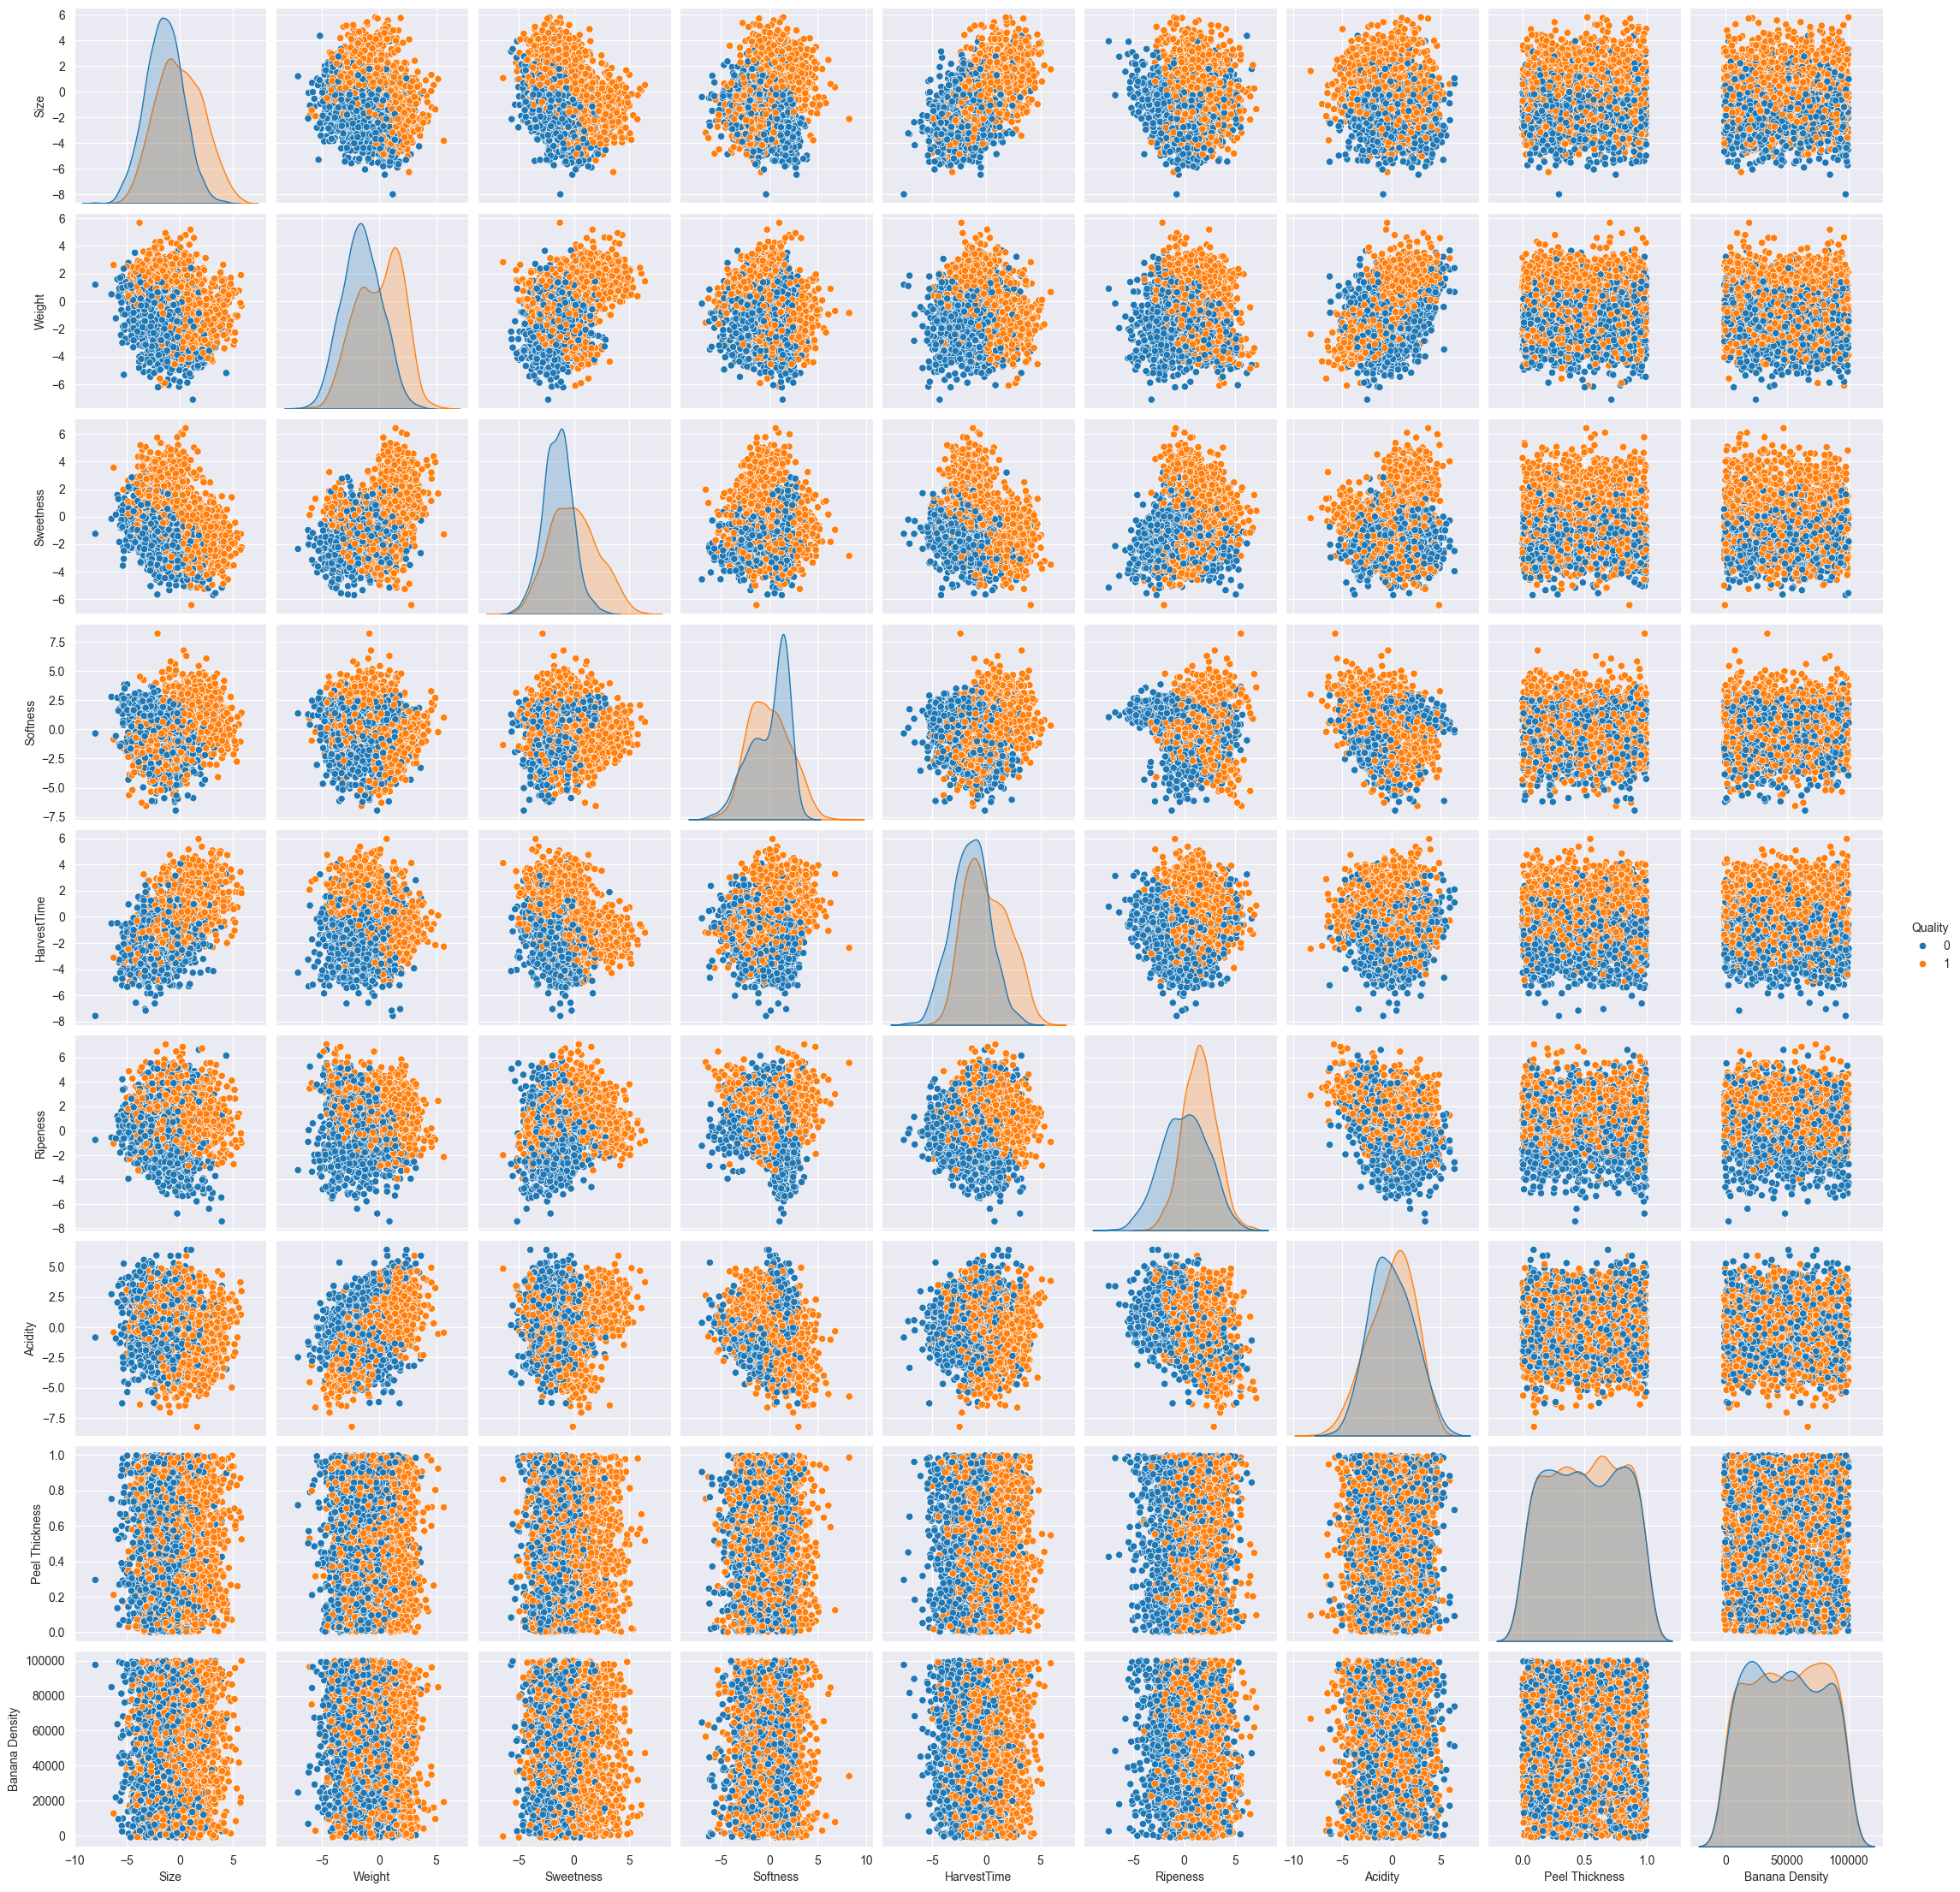

In [20]:
sns.pairplot(data=traindata, hue="Quality")

<Axes: >

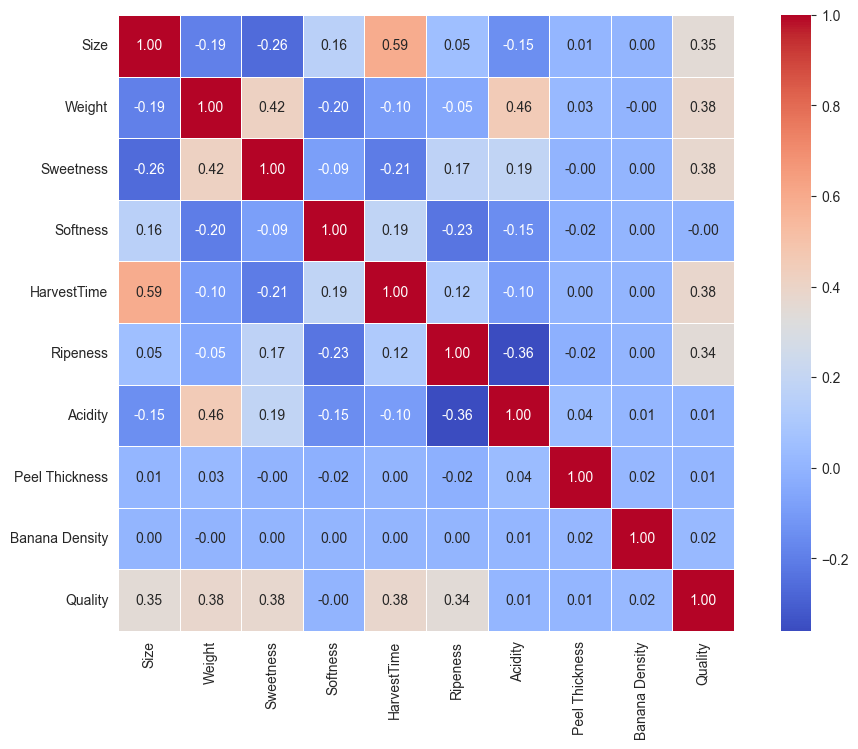

In [21]:
corr_matrix = traindata.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)

The pairplot gave a feeling that the two columns "Peel thickness" and "banana density" only added noise to the dataset and did not contribute with anything useful. This is the reason why a correlation heatmap was made.
The correlation heatmap for the two columns "Banana Density" and "Peel Thickness" confirms this suspisicion, as both columns basically only contain a correlation of zero.
Therefore, these two features will be removed.

## 2. Preprocessing

There are multiple steps of preprocessing which have shown to give a good result.

First we remove the selected features from before, since they have shown to have zero correlation.

Then, outliers are removed using interquartile range filtering, as this in training showed the best results

Finally, the data is scaled using the standardscaler

In [33]:
# Removing the features
X = traindata.drop(columns=["Quality", "Peel Thickness", "Banana Density"], axis=0)
X_test = testdata.drop(columns=["Peel Thickness", "Banana Density"], axis=0)
y = traindata["Quality"]

# ----------------------------------------#

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Creates a boolean mask which checks if any value in one row lies outside 2*IQR
# If one value of a row lies outside, the whole row is removed
mask = ~((X < (Q1 - 2.0 * IQR)) | (X > (Q3 + 2.0 * IQR))).any(axis=1)

# Applying the mask to the dataset
X = X[mask]
y = y[mask]

print(f"Removed {(~mask).sum()} outliers using 2.0 * IQR")

# ----------------------------------------#

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

Removed 12 outliers using 2.0 * IQR


## 3. Optimizing parameters for the SVM model
We chose to apply a kernel SVM model after having tried out multiple models. This gave the most amount of freedom and showed the best improvement when being optimized.
The goal with SVM models is to find the best hyperplane that separates the data with the maximum margin.
The kernel transforms data that is not linearly separable to higher dimensional space where it can be linearly separated. 
This task uses the standard rbf kernel from scikitlearn

In [ ]:
# The four parameters which are to be looped over 
C_values = np.linspace(5, 20, 16)        # 16 values between 5 and 20
gamma_values = np.linspace(0.05, 0.2, 16)  # 16 values between 0.05 and 0.2
test_sizes = [0.15, 0.175, 0.2, 0.225, 0.250, 0.275, 0.3]
random_states = list(range(10))  

results = []

# Looping over all 4 parameters
for test_size in test_sizes:
    for C in C_values:
        for gamma in gamma_values:
            for random_state in random_states:
                # Splitting based on the variable testsize and randomstate
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
                model = SVC(C=C, gamma=gamma)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                

                # Appending all possibilities to a list
                results.append({
                    "C": C,
                    "gamma": gamma,
                    "test_size": test_size,
                    "random_state": random_state,
                    "accuracy": acc
                })

# Convert to DataFrame
df_results = pd.DataFrame(results)

# Find the row with the highest accuracy
best_result = df_results.loc[df_results["accuracy"].idxmax()]
print("Best combination:")
print(best_result)

C=5.0, gamma=0.05, test_size=0.15, random_state=0 => Accuracy: 0.9714
C=5.0, gamma=0.05, test_size=0.15, random_state=1 => Accuracy: 0.9761
C=5.0, gamma=0.05, test_size=0.15, random_state=2 => Accuracy: 0.9785
C=5.0, gamma=0.05, test_size=0.15, random_state=3 => Accuracy: 0.9714
C=5.0, gamma=0.05, test_size=0.15, random_state=4 => Accuracy: 0.9666
C=5.0, gamma=0.05, test_size=0.15, random_state=5 => Accuracy: 0.9761
C=5.0, gamma=0.05, test_size=0.15, random_state=6 => Accuracy: 0.9785
C=5.0, gamma=0.05, test_size=0.15, random_state=7 => Accuracy: 0.9594
C=5.0, gamma=0.05, test_size=0.15, random_state=8 => Accuracy: 0.9785
C=5.0, gamma=0.05, test_size=0.15, random_state=9 => Accuracy: 0.9594
C=5.0, gamma=0.060000000000000005, test_size=0.15, random_state=0 => Accuracy: 0.9737
C=5.0, gamma=0.060000000000000005, test_size=0.15, random_state=1 => Accuracy: 0.9785
C=5.0, gamma=0.060000000000000005, test_size=0.15, random_state=2 => Accuracy: 0.9785
C=5.0, gamma=0.060000000000000005, test_si

## 4. Running the model on the testdata
Now that the optimal parameters have been found, and outliers have been removed, it is time to apply the model and parameters to the testdata

In [ ]:
best_config = {
    "C": 9.0,
    "gamma": 0.14,
    "test_size": 0.15,
    "random_state": 6
}

# Recreate the exact train/test split
X_train, X_unused, y_train, y_unused = train_test_split(X, y, test_size=best_config["test_size"], random_state=int(best_config["random_state"]))

# Create the model based on best parameters
model = SVC(C=best_config["C"], gamma=best_config["gamma"])
model.fit(X_train, y_train)

# predict!
y_kaggle_pred = model.predict(X_test)

Now that the prediction has been made, the only remaining step is to take the prediction and put it in the relevant file format to be uploaded to Kaggle. This is done in the code cell below. The file which is made should be exactly the same as submission 17 for group 25 on kaggle.

In [ ]:
submission_df = pd.DataFrame(y_kaggle_pred, columns=["Quality"])
submission_df.index = testdata.index
submission_df.index.name = "ID"

submission_df.to_csv("submission_final.csv")